# A4 - Python

This assignment will cover topics of clustering and association analysis.

Make sure that you keep this notebook named as "a4.ipynb" 

Any other packages or tools, outside those listed in the assignments or Canvas, should be cleared
by Dr. Brown before use in your submission.

## Q0 - Setup

The following code looks to see whether your notebook is run on Gradescope (GS), Colab (COLAB), or the linux Python environment you were asked to setup.

In [1]:
import re 
import os
import platform 
import sys 

# flag if notebook is running on Gradescope 
if re.search(r'amzn', platform.uname().release): 
    GS = True
else: 
    GS = False

# flag if notebook is running on Colaboratory 
try:
  import google.colab
  COLAB = True
except:
  COLAB = False

# flag if running on Linux lab machines. 
cname = platform.uname().node
if re.search(r'(guardian|colossus|c28)', cname):
    LLM = True 
else: 
    LLM = False

print("System: GS - %s, COLAB - %s, LLM - %s" % (GS, COLAB, LLM))

System: GS - False, COLAB - False, LLM - True


## Notebook Setup

It is good practice to list all imports needed at the top of the notebook. You can import modules in later cells as needed, but listing them at the top clearly shows all which are needed to be available / installed.

If you are doing development on Colab, the otter-grader package is not available, so you will need to install it with pip (uncomment the cell directly below).

In [2]:
# Only uncomment if you developing on Colab 
# if COLAB == True: 
#     print("Installing otter:")
#     !pip install otter-grader==4.2.0 
# %pip install mlxtend --upgrade
# !pip install mlxtend

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn import cluster
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy
from sklearn.decomposition import PCA


from mlxtend.preprocessing import TransactionEncoder 
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth


# Package for Autograder 
import otter 
grader = otter.Notebook()

/home/campus12/bmangiso/.conda/envs/cs4821/lib/python3.8/site-packages/IPython/core/inputsplitter.py:21: DeprecationWarning: IPython.core.inputsplitter is deprecated since IPython 7 in favor of `IPython.core.inputtransformer2`
  warn('IPython.core.inputsplitter is deprecated since IPython 7 in favor of `IPython.core.inputtransformer2`',


In [4]:
grader.check("q0")

q0 results: All test cases passed!

# Q1 : Clustering - Premiere League Players 

Let's consider methods to cluster Premiere League players based on their statistics.  



## Q1(a) - Load the data

Load the Premiere League data into a DataFrame `q1df`.  Make sure any missing data is encoded properly. 

In [5]:
# Read in football data with pandas "read_csv" function
#  Use column names from the original csv file 

q1df = pd.read_csv("data/premierleague-data.csv", na_values="")

q1df.head()

,Name,Jersey Number,Club,Position,Nationality,Age,Appearances,Wins,Losses,Goals,...,Punches,High Claims,Catches,Sweeper clearances,Throw outs,Goal Kicks,Yellow cards,Red cards,Fouls,Offsides
0,Bernd Leno,1.0,Arsenal,Goalkeeper,Germany,28.0,64,28,16,0,...,34.0,26.0,17.0,28.0,375.0,489.0,2,0,0,NaN
1,Matt Macey,33.0,Arsenal,Goalkeeper,England,26.0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,NaN
2,Rúnar Alex Rúnarsson,13.0,Arsenal,Goalkeeper,Iceland,25.0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,NaN
3,Héctor Bellerín,2.0,Arsenal,Defender,Spain,25.0,160,90,37,7,...,NaN,NaN,NaN,NaN,NaN,NaN,23,0,125,8.0
4,Kieran Tierney,3.0,Arsenal,Defender,Scotland,23.0,16,7,5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,2,0,9,0.0


In [6]:
grader.check("q1a")

q1a results: All test cases passed!

## Q1(b) - Clean the Data 

There are a lot of missing values in the data set.  

Complete the following preprocessing steps. 

1. Remove any player without at least 21 appearances. 
2. Remove all Goalkeepers (they have different statistics than other players on the field. 
3. Remove columns 10, 21, 22, 25, 30, 37, 47-54 (most of these columns have to do with Goalkeeper's statistics). 
4. Remove any rows with missing values

In [7]:
# Complete steps to clean the data  

# Remove players < 21 appearances
index = q1df[q1df.Appearances < 21].index
q1df.drop(index, inplace = True)

# Remove Goal keepers
index = q1df[q1df.Position == "Goalkeeper"].index
q1df.drop(index, inplace = True)

# Remove columns 10, 21,22,25,30,37,47-54
removeIndexes = [10,21,22,25,30,37]
removeColumns = [q1df.columns[i] for i in removeIndexes]
columns = list(q1df.columns[:47])
columns = columns + list(q1df.columns[55:])
columns = [col for col in columns if col not in removeColumns]

q1df = q1df[columns]
# Remove rows with missing values
q1df.dropna(inplace = True)

q1df.head(20)

,Name,Jersey Number,Club,Position,Nationality,Age,Appearances,Wins,Losses,Goals,...,Passes per match,Big chances created,Crosses,Cross accuracy %,Through balls,Accurate long balls,Yellow cards,Red cards,Fouls,Offsides
13,Mesut Özil,10.0,Arsenal,Midfielder,Germany,31.0,184,100,39,33,...,60.79,65.0,834.0,35%,121.0,276.0,13,0,95,83.0
14,Lucas Torreira,11.0,Arsenal,Midfielder,Uruguay,24.0,63,28,15,3,...,39.57,3.0,40.0,28%,4.0,94.0,14,1,62,0.0
15,Ainsley Maitland-Niles,15.0,Arsenal,Midfielder,England,23.0,54,26,16,1,...,34.57,4.0,57.0,21%,2.0,74.0,6,2,35,1.0
16,Mohamed Elneny,25.0,Arsenal,Midfielder,Egypt,28.0,47,29,10,0,...,53.87,2.0,30.0,13%,4.0,83.0,7,1,24,2.0
17,Joseph Willock,28.0,Arsenal,Midfielder,England,21.0,33,12,12,1,...,12.06,1.0,9.0,22%,3.0,15.0,2,0,13,0.0
18,Matteo Guendouzi,29.0,Arsenal,Midfielder,France,21.0,57,24,17,0,...,48.25,4.0,21.0,10%,16.0,148.0,15,0,41,0.0
20,Granit Xhaka,34.0,Arsenal,Midfielder,Switzerland,27.0,132,70,33,8,...,73.78,12.0,274.0,25%,35.0,673.0,35,2,196,2.0
22,Dani Ceballos,8.0,Arsenal,Midfielder,Spain,24.0,26,14,6,0,...,52.77,2.0,71.0,14%,7.0,81.0,1,0,21,0.0
44,Douglas Luiz,6.0,Aston-Villa,Midfielder,Brazil,22.0,37,10,20,3,...,35.14,3.0,25.0,24%,4.0,100.0,8,0,51,0.0
45,John McGinn,7.0,Aston-Villa,Midfielder,Scotland,25.0,29,7,15,3,...,26.17,3.0,67.0,21%,3.0,85.0,4,0,38,0.0


In [8]:
grader.check("q1b")

q1b results: All test cases passed!

## Q1c - Prepare the Data

The first 5 columns, `Name`, `Jersey Number`, `Club`, `Position`, and `Nationality` will not be used in the clustering analysis, this data is just helpful to label the players. 

The `Age` column does not need any initial preprocssing.  

There are three columns that report percentages: `Shooting accuracy %`, `Tackle success %`, `Cross accuracy %`.  For each of these columns, remove the "%" from the string convert to a number.  

The remaining data presented is "counts" data, e.g., number of `Goals`, number of `Tackles`, number of `Recoveries`, etc.  The counts data will be impacted by the number of games a player has appeared in; those players appearing in hundreds of games rather than tens of games will generally have higher values. 

Therefore, rather than work directly with the counts data, you should normalize these values by the number of appearances. 

At this point all column after the Appearance should be scaled using standard scaling. 

Store the player's numeric data (columns `Wins` and later) to be used for clustering in the Data Frame `football`. 

In [9]:
# Preprocess the data     
football = q1df.iloc[:,5:]
football["Shooting accuracy %"] = pd.to_numeric(football["Shooting accuracy %"].apply(lambda x: x[:-1]))
football["Tackle success %"] = pd.to_numeric(football["Tackle success %"].apply(lambda x: x[:-1]))
football["Cross accuracy %"] = pd.to_numeric(football["Cross accuracy %"].apply(lambda x: x[:-1]))

for col in football.iloc[:,2:].columns:
  football[col] = football[col]/football.iloc[:,1]

football = football.iloc[:,2:]
football = (football-football.mean())/football.std()

football.head()

,Wins,Losses,Goals,Headed goals,Goals with right foot,Goals with left foot,Penalties scored,Freekicks scored,Shots,Shots on target,...,Passes per match,Big chances created,Crosses,Cross accuracy %,Through balls,Accurate long balls,Yellow cards,Red cards,Fouls,Offsides
13,0.913414,-1.164877,1.345068,0.804052,-0.564072,2.633675,-0.300033,0.119915,0.091408,0.795089,...,-0.502755,2.486610,1.480604,-0.537797,2.992195,-0.313924,-0.849792,-0.540723,-1.035314,3.526698
14,0.284271,-0.973186,-0.549780,-0.475486,-0.039210,-0.678075,-0.300033,-0.386663,-0.648526,-0.692685,...,0.210934,-0.812223,-0.727558,0.404062,-0.627423,-0.320307,1.278823,1.260600,0.346281,-0.801955
15,0.519560,-0.546361,-0.968375,-0.475486,-0.629388,-0.678075,-0.300033,-0.386663,-1.555975,-1.252190,...,0.239916,-0.526691,-0.489255,0.198240,-0.788598,-0.418181,-0.281596,3.662363,-0.645947,-0.624251
16,1.380619,-1.158941,-1.234754,-0.475486,-1.004955,-0.678075,-0.300033,-0.386663,-0.251531,-1.096892,...,1.452876,-0.866900,-0.725644,-0.217783,-0.495739,-0.100023,0.249611,1.873816,-1.052047,-0.393613
17,-0.229088,-0.052514,-0.798861,-0.475486,-0.390390,-0.678075,-0.300033,-0.386663,-1.004461,-0.879958,...,-0.418674,-0.999117,-0.932751,1.227350,-0.460386,-1.154750,-0.990877,-0.540723,-1.396688,-0.801955


In [10]:
grader.check("q1c")

q1c results: All test cases passed!

## Q1(d) - Kmeans Clustering

Run Kmeans clustering on the football data with $k$ = 2, ..., 10.  Set the `random_state` in the Kmeans algorithm to 7.  For each value of $k$, keep track of the within-cluster variation (in `scikit-learn` this is called `inertia`), the Calinski-Harabasz score, and the Davies-Bouldin index on the resulting clusters.  

We will examine the different values to decide what number of clusters to focus on. 

In [11]:
# Run Kmeans clustering on the football data 
sse = []
dbscore = []
chscore = []

for k in range(2,11):
  # fit data
  km = cluster.KMeans(n_clusters=k, random_state=7)
  km.fit(football)

  # predict
  y_pred = km.predict(football)

  # calculate scores
  sse.append(km.inertia_)
  dbscore.append(metrics.davies_bouldin_score(football, y_pred))
  chscore.append(metrics.calinski_harabasz_score(football, y_pred))



## Q1(e) - Kmeans Cluster Results 

Plot the intertia versus the number of clusters. 

Also, plot CH Index and DB Index vs. the number of cluster (3 plots total).

Report the best number of clusters, `bestk`, using DB index.  

Text(0, 0.5, 'Inertia')

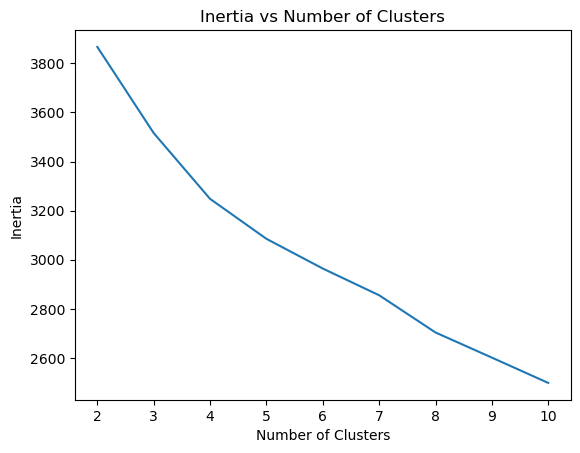

In [12]:
# Plot interia vs number of clusters 

plt.plot(range(2,11), sse)
plt.title("Inertia vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")

Text(0, 0.5, 'CH Index')

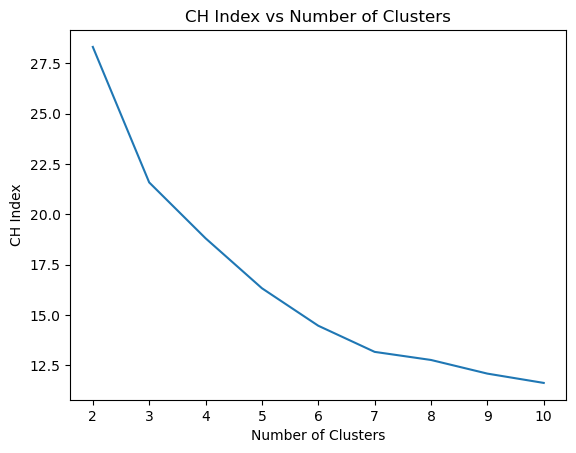

In [13]:
# Plot CH Index  vs number of clusters 

plt.plot(range(2,11), chscore)
plt.title("CH Index vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("CH Index")

Text(0, 0.5, 'DB Index')

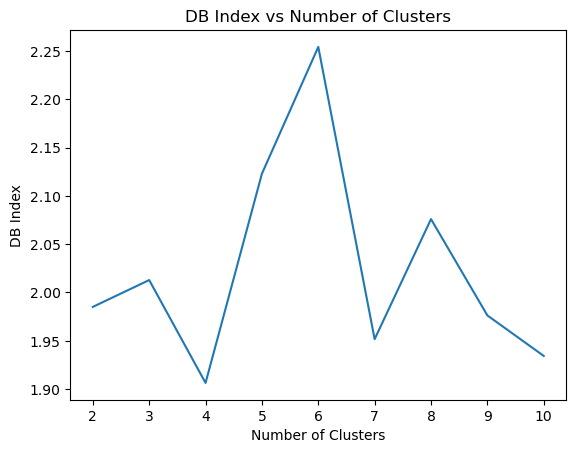

In [14]:
# Plot DB Index vs number of clusters 

plt.plot(range(2,11), dbscore)
plt.title("DB Index vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("DB Index")

In [15]:
# Select best number of clusters using DB Index. 

bestk = 4


In [16]:
grader.check("q1e")

q1e results:
    q1e - 1 result:
        ❌ Test case failed
        Trying:
            bestk == 5
        Expecting:
            True
        **********************************************************************
        Line 1, in q1e 0
        Failed example:
            bestk == 5
        Expected:
            True
        Got:
            False

## Q1(f) - Prototypical Stats 

Using the best number of clusters from above. Run Kmeans with this value for $k$ (again use `random_state=7`). 

Create a Data Frame, `clusterStats`,  with the mean statistics (centers) for each cluster.  The Data Frame should be rows: cluster groups 0, 1, 2, ..., bestk-1 and columns: mean statistics.  

Add a column `Num` to this DataFrame reporting the number of samples in each group. 

In [17]:
# Create a DataFrame "clusterStats" with the mean statistics (centers) for each 
#  cluster
km = cluster.KMeans(n_clusters=5, random_state=7)
km.fit(football)

# predict
y_pred = km.predict(football)

football["Num"] = y_pred

clusterStats = football.groupby("Num", as_index=False).mean()

temp_cols = clusterStats.columns.tolist()
new_cols = temp_cols[1:] + temp_cols[0:1]
clusterStats = clusterStats[new_cols]

clusterStats.head(10)

,Wins,Losses,Goals,Headed goals,Goals with right foot,Goals with left foot,Penalties scored,Freekicks scored,Shots,Shots on target,...,Big chances created,Crosses,Cross accuracy %,Through balls,Accurate long balls,Yellow cards,Red cards,Fouls,Offsides,Num
0,-0.015941,0.008567,-0.346874,-0.100034,-0.240191,-0.254778,-0.289862,-0.386663,-0.396732,-0.328208,...,-0.361680,-0.470322,0.131360,-0.391545,-0.698347,-0.560333,-0.287995,-0.767967,0.005961,0
1,-0.079605,0.137605,-0.857033,-0.365079,-0.587540,-0.585423,-0.244963,-0.386663,-0.750908,-0.796712,...,-0.602151,-0.407931,1.005528,-0.369910,0.471720,0.536846,0.483940,0.459982,-0.603487,1
2,0.885228,-0.822643,2.830120,3.131053,2.311714,0.766263,0.750229,-0.028161,2.517698,2.772221,...,1.879606,0.308190,-0.528485,1.617157,0.147591,-0.392820,-0.169950,0.573644,1.079892,2
3,-0.092688,0.116389,0.631125,-0.088489,0.314149,0.715959,0.028957,0.565123,0.736987,0.732761,...,0.708439,0.882642,-0.207580,0.360537,-0.392219,-0.395173,-0.251175,-0.386422,0.563241,3
4,0.056492,-0.140853,-0.314287,-0.019065,-0.113732,-0.389163,0.313304,-0.081298,-0.446126,-0.512435,...,-0.453687,-0.478872,-0.581556,-0.091937,0.799422,0.709520,0.253312,0.794903,-0.469390,4


In [18]:
grader.check("q1f")

q1f results: All test cases passed!

## Q1(g) - Plot Clusters 

Apply PCA to the football data.  Plot the first two principal components, colored by the best group labels found in Q1(f).  

Text(0, 0.5, 'PCA 2')

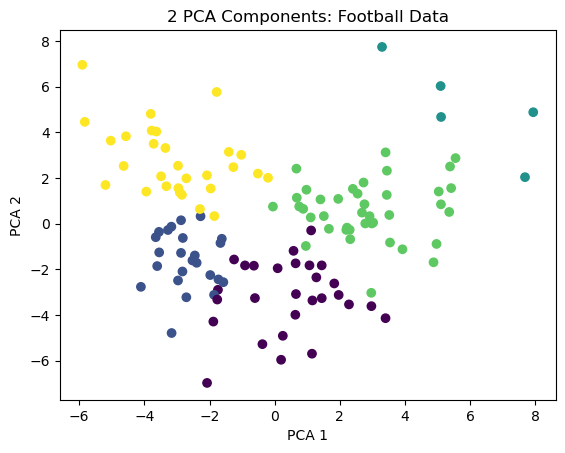

In [19]:
# Run PCA on the football data and plot the first two principal components
#  colored by the group labels. 

pca = PCA(n_components=2)
pca.fit(football)

components = pca.transform(football)

plt.scatter(components[:,0],components[:,1], c=football["Num"])
plt.title("2 PCA Components: Football Data")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")


# Q2 : Clustering - Spotify Music

For this problem you will look at popular streaming music.  Specifically, Spotify's top 100 streaming songs.  For each song information about the song is described with different properties: `duration`, `energy`, `key`, etc. 


## Q2(a) - Load and Prepare the Data 

Load in the `music.csv` data.  

The clustering algorithms will only consider variables of `duration` to the end of the DataFrame. 

Standardize the variables to be used in clustering.  

In [21]:
# Load in music data 

music = pd.read_csv("data/music.csv")

music.iloc[:,5:] = (music.iloc[:,5:]-music.iloc[:,5:].mean())/music.iloc[:,5:].std()

music.head()

,Song,Artist,Streams (Billions),Release Date,id,duration,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,danceability
0,Blinding Lights,The Weeknd,3.449,29-Nov-19,0VjIjW4GlUZAMYd2vXMi3b,-0.377848,0.652942,-1.196543,0.120637,0.730121,-0.412369,-0.951353,-0.158298,-0.618407,-0.746964,1.683946,-0.937853
1,Shape of You,Ed Sheeran,3.398,06-Jan-17,7qiZfU4dY1lWllzX7mPBI3,0.327600,0.165579,-1.196543,1.490262,-1.355939,-0.182825,1.173344,-0.160246,-0.590735,1.906921,-0.855557,1.212646
2,Dance Monkey,Tones And I,2.770,10-May-19,2XU0oxnq2qxCpomAAuJY8K,-0.179827,-0.234309,0.181963,-0.111367,-1.355939,-0.045549,1.580290,-0.158123,-0.135772,0.048757,-0.786170,1.205731
3,Someone You Loved,Lewis Capaldi,2.680,08-Nov-18,7qEHsqek33rTcFNT9PFqLf,-0.736760,-1.377739,-1.196543,0.247593,0.730121,-0.726305,1.796594,-0.160246,-0.493882,-0.249083,-0.384605,-1.027745
4,Rockstar,Post Malone featuring 21 Savage,2.620,15-Sep-17,0e7ipj03S05BNilyu5bRzt,0.005817,-0.659190,-0.093738,0.020069,-1.355939,-0.284095,-0.502100,-0.158815,-0.282272,-1.658265,1.304719,-0.446903


In [22]:
grader.check("q2a")

q2a results: All test cases passed!

## Q2(b) - Hierarchical Clustering 

Perform Hierarchical clustering with **single** linkage on just the top 30 songs. 

Report results in a dendrogram, `dg_single` and label the samples by the Artist.  



(29, 4)


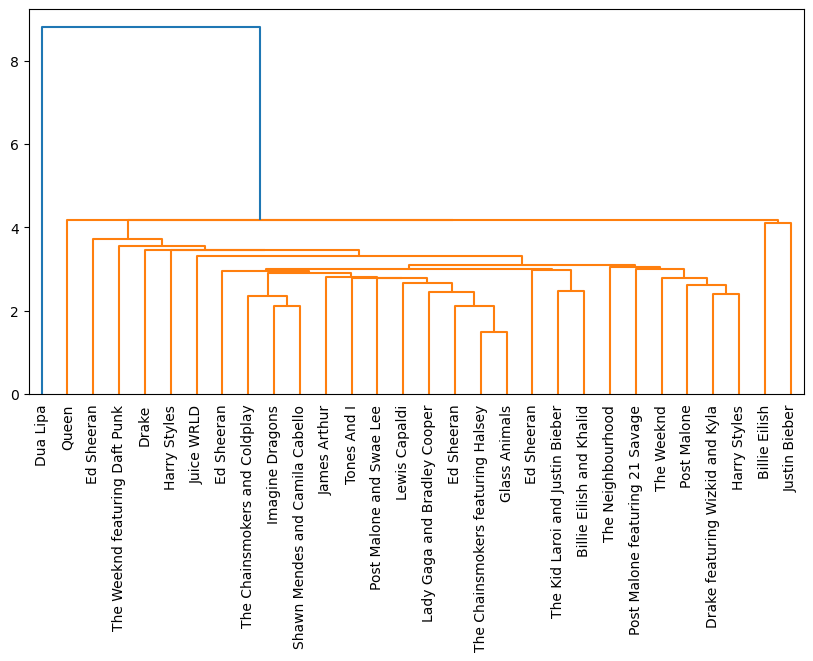

In [23]:
# Perform Hierarchical clustering with single linkage on top 30 songs 
# Report results in a dendrogram, dg_single
hc = cluster.AgglomerativeClustering(distance_threshold=0, 
n_clusters=None, linkage="single")

y_pred = hc.fit_predict(music.iloc[:30,5:])

linkage = hierarchy.linkage(music.iloc[:30,5:], 'single')
plt.figure(figsize=(10, 5))
print(linkage.shape)
dg_single = hierarchy.dendrogram(linkage, labels=list(music.iloc[:30,1]),
    leaf_rotation = 90)

In [24]:
grader.check("q2b")

q2b results: All test cases passed!

## Q2(c) - Hierarchical Clustering, part 2 

Perform Hierarchical clustering with **complete** linkage on just the top 30 songs.

Report results in a dendrogram, `dn_complete` and label the samples by the Artist.

(29, 4)


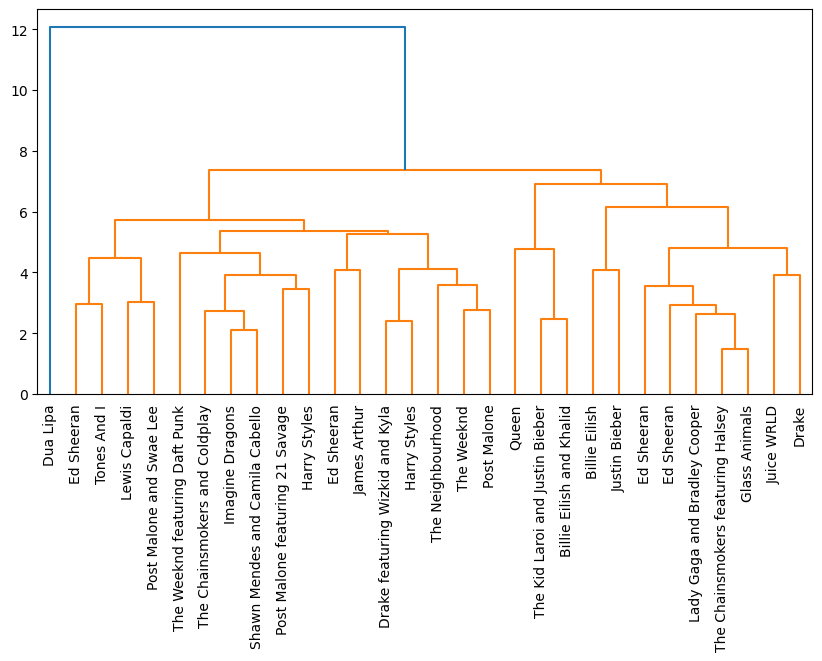

In [25]:
# Perform Hierarchical clustering with complete linkage on top 30 songs 
# Report results in a dendrogram, dg_complete
hc2 = cluster.AgglomerativeClustering(distance_threshold=0, 
n_clusters=None, linkage="complete")
y_pred = hc2.fit_predict(music.iloc[:30,5:])

linkage = hierarchy.linkage(music.iloc[:30,5:], 'complete')
plt.figure(figsize=(10, 5))
print(linkage.shape)
dg_complete = hierarchy.dendrogram(linkage, labels=list(music.iloc[:30,1]),
    leaf_rotation = 90)

In [26]:
grader.check("q2c")

q2c results: All test cases passed!

## Q2(d) - Hierarchical Clustering, part 3

Perform Hierarchical clustering with **aveage** linkage on just the top 30 songs.

Report results in a dendrogram, `dn_average` and label the samples by the Artist.

(29, 4)


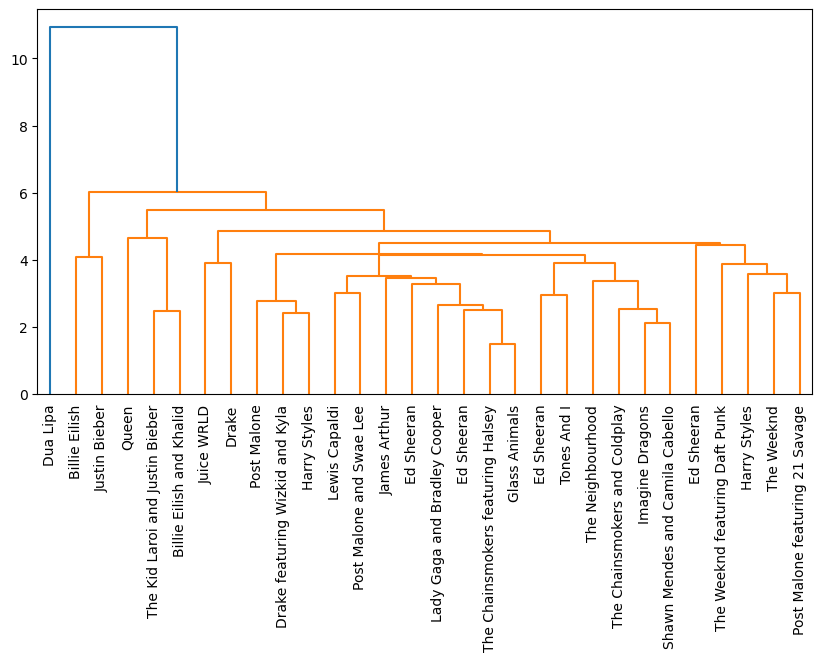

In [27]:
# Perform Hierarchical clustering with average linkage on top 30 songs 
# Report results in a dendrogram, dg_average
hc2 = cluster.AgglomerativeClustering(distance_threshold=0, 
n_clusters=None, linkage="average")
y_pred = hc2.fit_predict(music.iloc[:30,5:])

linkage = hierarchy.linkage(music.iloc[:30,5:], 'average')
plt.figure(figsize=(10, 5))
print(linkage.shape)
dg_average = hierarchy.dendrogram(linkage, labels=list(music.iloc[:30,1]),
    leaf_rotation = 90)

In [28]:
grader.check("q2d")

q2d results: All test cases passed!

# Q3 - Association Analysis

For this problem, you will analyze a portion of the Instacart Online Grocery Shopping Dataset from 2017.  The full data set is available if you are interested.  
https://www.instacart.com/datasets/grocery-shopping-2017

We will work with a smaller data set containing just 20K items purchased,  the medium data set has 500K items purchased, adn the original dataset has 3 million orders. 

You will use the following files for this analysis: 

* `order_products__train_small.csv`  
* `products.csv` 

The file `order_products__train_small.csv` have items indexed by a number.  You can connect these values with the name of the product in the `products.csv` file.  


## Q3(a) - Load the Data

Load the 2 data files mentioned above.  
You will need to transform this data into a boolean transaction DataFrame for the small data `orders_small`.  

These boolean transaction DataFrame will have rows corresponding to orders / transaction with the `order_id` as the row names.  The DataFrame will have columns corresponding to products with the `product_name` as the column names.  The DataFrame is boolean and entry [i, j] is : "False" meaning this product, j, was not purchased in order, i, and "True" means product, j, was purchased in order, i. 

The rows in the DataFrame should be in order of `order_id`.  The columns should be ordered in alphanumeric ordering of the `product_name`.

Note, you can not use the `mlxtend.TransactionEncoder` function for this because it expects data as lists of lists.  



In [29]:
# Load and prepare the data 
# get datasets
data1 = pd.read_csv("data/instacart-small/order_products__train_small.csv")

data2 = pd.read_csv("data/instacart-small/products.csv")

data2.head()

# join datasets
joinedData = data1.merge(data2, on="product_id").iloc[:,[0,1,4]]

# group and aggregate group items
txns = joinedData.groupby('order_id').product_name.agg([("count","count"),('items', '[###]'.join)])

# convert to list of lists
orderTxns = []
for index, row in txns.iterrows():
  orderTxns.append(row["items"].split("[###]"))

# convert to boolean dataframe
te = TransactionEncoder()
tedata = te.fit(orderTxns).transform(orderTxns)
orders_small = pd.DataFrame(tedata, columns=te.columns_, index=txns.index)
sorted_columns = list(orders_small.columns)
sorted_columns.sort(key=str.casefold)
orders_small = orders_small[sorted_columns]

orders_small.head()

,#2 Coffee Filters,0% Fat Free Organic Milk,0% Fat Organic Greek Vanilla Yogurt,0% Fat Superfruits Greek Yogurt,0% Greek Strained Yogurt,1 Apple + 1 Pear Fruit Bar,1 Liter,1 Ply Paper Towels,1% Chocolate Milk,1% Low Fat Milk,...,Zero Dish Soap Fragrance Free,Zero Go-Go Mixed Berry Vitamin Water,Zero Soda,Zero Strawberry Lemon,Zero Vitamin Water,Zesta Original Saltine Crackers,Zesty Garlic Aiolo Mayo Alternative,Zesty Lemon Hommus,Zucchini Noodles,Zucchini Squash
order_id,,,,,,,,,,,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
36,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
38,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
96,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
98,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [30]:
grader.check("q3a")

q3a results:
    q3a - 1 result:
        ✅ Test case passed

    q3a - 2 result:
        ✅ Test case passed

    q3a - 3 result:
        ✅ Test case passed

    q3a - 4 result:
        ✅ Test case passed

    q3a - 5 result:
        ❌ Test case failed
        Trying:
            all(orders_small.iloc[190:200, 500] == [False, False, True, False, True,  
                                                    False, False, False, False, False])
        Expecting:
            True
        **********************************************************************
        Line 1, in q3a 4
        Failed example:
            all(orders_small.iloc[190:200, 500] == [False, False, True, False, True,  
                                                    False, False, False, False, False])
        Expected:
            True
        Got:
            False

## Q3(b) - Explore the Data 

Create a density plot showing the number of products per order for the small sets.

Also, calculate the mean number of products per order for the small dataset. 

Mean number of products per order - Small:  10.604984093319194


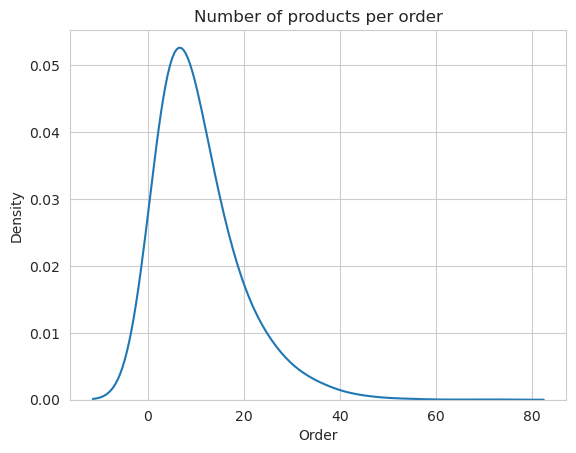

In [31]:
# Plot the number of products per order 


sb.set_style('whitegrid')
sb.kdeplot(txns["count"], bw_method=0.5)
plt.title("Number of products per order")
plt.xlabel('Order')
plt.ylabel('Density')

mn_num_sm = txns["count"].mean()


print("Mean number of products per order - Small: ", mn_num_sm)

In [32]:
grader.check("q3b")

q3b results: All test cases passed!

<!-- BEGIN QUESTION -->

## Q3(c) - Explore the Data, part 2 

For the samll dataset, create an top 15 item frequency plot, that is plot the top 15 most frequently purchased items. This should be a bar plot with items vs. frequency (relative support).

Text(0.5, 1.0, 'Top 15 most frequently purchased product')

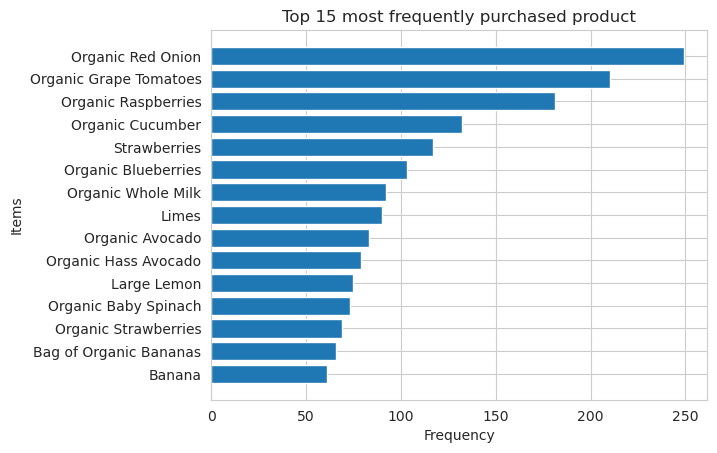

In [33]:
# Plot top 15 most frequently purchased product (by relative support)

sup = orders_small.sum()
top15 = sup.sort_values(ascending=False)[:15]

plt.barh(top15.index, top15.sort_values())
plt.xlabel('Frequency')
plt.ylabel('Items')
plt.title('Top 15 most frequently purchased product')




<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Q3(d) - Explore the Data, part 3 

For the small dataset, create an histogram of the number of times an item is purchased. You may want to consider using log scaling to view the data distribution more easily. 

Text(0, 0.5, 'Number of purchases')

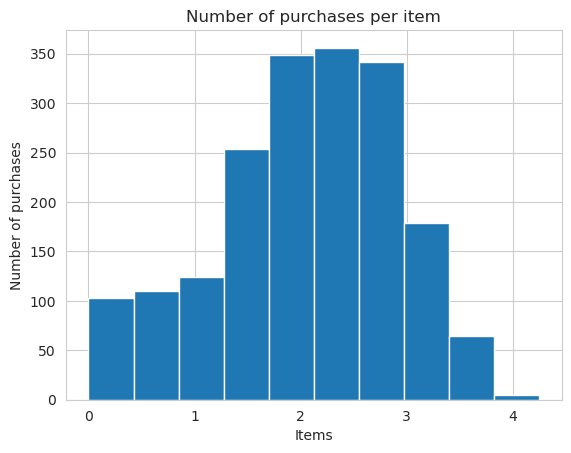

In [34]:
# Plot histogram of number of purchases per item. 
logData = np.log(txns["count"])

plt.hist(logData)
plt.title("Number of purchases per item")
plt.xlabel("Items")
plt.ylabel("Number of purchases")




<!-- END QUESTION -->

## Q3(e) - Apriori 

For the small dataset, use Apriori to find association rules, `rules_sm` with a minimum support of 0.0035 and confidence of 0.5.  

Store the top 20 rules sorted by leverage in `q3e_df`.

Note, the minimum support level is rather high given the information plotted in Q3(c) and Q3(d). However, this was done to avoid using too much memory (lower support values will require 15-20 GB memory). 

In [35]:
# Run Apriori as instructed

fi = apriori(orders_small, min_support=0.0035, use_colnames=True)

rules_sm = association_rules(fi, metric='confidence', min_threshold=0.5).iloc[:,:-1].sort_values(["leverage"], ascending=False)

q3e_df = rules_sm.iloc[:20,:]

q3e_df.iloc[0:10, [0, 1, 4, 5, 6]]

,antecedents,consequents,support,confidence,lift
14,"(Bag of Organic Bananas, Organic Raspberries)",(Organic Hass Avocado),0.005832,0.500000,9.155340
6,(Roma Tomato),(Banana),0.006893,0.500000,3.787149
15,"(Organic Hass Avocado, Organic Raspberries)",(Bag of Organic Bananas),0.005832,0.647059,5.811204
18,"(Organic Avocado, Limes)",(Large Lemon),0.004772,0.529412,8.533937
16,"(Organic Strawberries, Organic Large Extra Fan...",(Bag of Organic Bananas),0.005302,0.526316,4.726817
20,"(Organic Avocado, Organic Red Onion)",(Limes),0.004242,0.800000,16.764444
11,"(Asparagus, Limes)",(Large Lemon),0.004242,0.888889,14.328585
10,"(Asparagus, Large Lemon)",(Limes),0.004242,0.666667,13.970370
22,"(Organic Garnet Sweet Potato (Yam), Limes)",(Organic Baby Spinach),0.004242,0.800000,11.430303
21,"(Organic Red Onion, Limes)",(Organic Avocado),0.004242,0.500000,10.250000


In [36]:
grader.check("q3e")

q3e results:
    q3e - 1 result:
        ✅ Test case passed

    q3e - 2 result:
        ✅ Test case passed

    q3e - 3 result:
        ✅ Test case passed

    q3e - 4 result:
        ❌ Test case failed
        Trying:
            rules_sm.iloc[2,0] == frozenset({'Organic Unsalted Butter'})
        Expecting:
            True
        **********************************************************************
        Line 1, in q3e 3
        Failed example:
            rules_sm.iloc[2,0] == frozenset({'Organic Unsalted Butter'})
        Expected:
            True
        Got:
            False

    q3e - 5 result:
        ❌ Test case failed
        Trying:
            rules_sm.iloc[23, 1] == frozenset({'Organic Baby Spinach'})
        Expecting:
            True
        **********************************************************************
        Line 1, in q3e 4
        Failed example:
            rules_sm.iloc[23, 1] == frozenset({'Organic Baby Spinach'})
        Expected:
            True
        Got:
            False

    q3e - 6 result:
        ✅ Test case passed

    q3e - 7 result:
        ✅ Test case passed

    q3e - 8 result:
        ✅ Test case passed

    q3e - 9 result:
        ✅ Test case passed

<!-- BEGIN QUESTION -->

## Q3(f) - Apriori, part 2

Create a scatterplot of the rules, plotting support vs. confidence colored by lift value. 


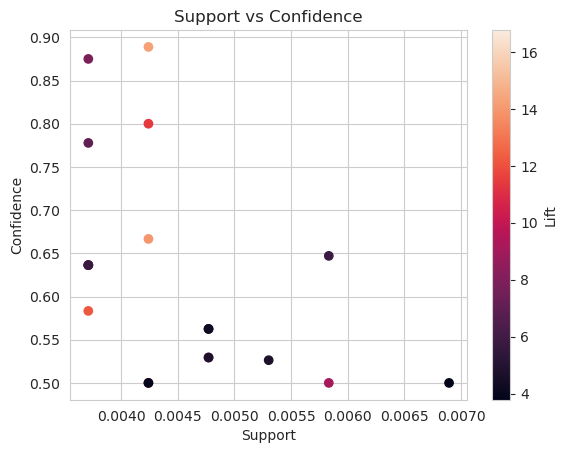

In [37]:
# Plot the results of Apriori

plt.scatter(q3e_df["support"],q3e_df["confidence"], c=q3e_df["lift"])
plt.title("Support vs Confidence")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.colorbar(label="Lift", orientation="vertical")

<!-- END QUESTION -->

## Q3(g) - FPGrowth 

For the small dataset, use FPGrowth to find association rules, `rules_sm2` with a minimum support of 0.002 and confidence of 0.5.

Store the top 20 rules sorted by leverage in `q3g_df`.

Note, the minimum support level is much lower here than in Q3(e) for Apriori.  The FPGrowth compactly stores the information necessary to calculate the frequent item patterns.

In [38]:
# Run FPGrowth as instructed

# Generate frequent itemsets with a minimum support of 0.0035 using the FP-Growth algorithm
fi = fpgrowth(orders_small, min_support=0.002, use_colnames=True)

# Generate association rules with a minimum confidence of 0.5
rules_sm2 = association_rules(fi, metric='confidence', min_threshold=0.5).sort_values(["leverage"], ascending=False).iloc[:,:-1]

# Sort the association rules by leverage 
q3g_df = rules_sm2.iloc[:20,:]


q3g_df.iloc[0:10, [0, 1, 4, 5, 6]]

,antecedents,consequents,support,confidence,lift
37,"(Bag of Organic Bananas, Organic Raspberries)",(Organic Hass Avocado),0.005832,0.500000,9.155340
190,(Roma Tomato),(Banana),0.006893,0.500000,3.787149
38,"(Organic Hass Avocado, Organic Raspberries)",(Bag of Organic Bananas),0.005832,0.647059,5.811204
130,"(Organic Avocado, Limes)",(Large Lemon),0.004772,0.529412,8.533937
147,"(Organic Strawberries, Organic Large Extra Fan...",(Bag of Organic Bananas),0.005302,0.526316,4.726817
249,"(Organic Avocado, Organic Red Onion)",(Limes),0.004242,0.800000,16.764444
2,"(Asparagus, Limes)",(Large Lemon),0.004242,0.888889,14.328585
1,"(Asparagus, Large Lemon)",(Limes),0.004242,0.666667,13.970370
4,"(Organic Garnet Sweet Potato (Yam), Limes)",(Organic Baby Spinach),0.004242,0.800000,11.430303
250,"(Organic Red Onion, Limes)",(Organic Avocado),0.004242,0.500000,10.250000


In [39]:
grader.check("q3g")

q3g results: All test cases passed!